# Setups

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import logomaker
import glob

from adjustText import adjust_text

import os
import pickle

import torch
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

import Bio.Align
from pymoo.indicators.hv import HV
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.manifold import SpectralEmbedding

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from matplotlib.patches import Ellipse, Rectangle

In [3]:
def hex_to_rgb(value: str) -> list:
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    
def hex_interpolate(init, fin, scale: float) -> str:
    if isinstance(init, str):
        init_rgb= np.array(hex_to_rgb(init))
    else:
        init_rgb= 255*np.asarray(init)
    if isinstance(fin, str):
        fin_rgb= np.array(hex_to_rgb(fin))
    else:
        fin_rgb= 255*np.asarray(fin)
    
    color_rgb= (init_rgb + scale*(fin_rgb - init_rgb))/255.
    
    return tuple(color_rgb)

In [4]:
sns.set(font_scale= 1., font= 'Arial')
sns.set_style('ticks')

In [5]:
def des_identity(WT_seq, seqs):
    WT_arr= np.array(list(WT_seq))
    seqs_arr= np.array([list(seq) for seq in seqs])
    identities= np.sum(seqs_arr == WT_arr, axis= -1)/len(WT_arr)
    return identities

In [6]:
bright_colors= sns.color_palette('bright')

cb_colors= np.array([
    [221, 221, 221],
    [46, 37, 133],
    [51, 117, 56],
    [93, 168, 153],
    [148, 203, 236],
    [220, 205, 125],
    [194, 106, 119],
    [159, 74, 150],
    [126, 41, 84]
])/255

In [7]:
# use this package to calculate approximate hypervolume
import pygmo as pg

def compute_approximate_hv(pop, ref_point):
    fpras= pg.bf_fpras(eps= 0.1, delta= 0.05, seed= 1)
    pg_hv= pg.hypervolume(pop)
    approximate_hv= pg_hv.compute(ref_point, hv_algo= fpras)
    return approximate_hv

In [8]:
blosum62= Bio.Align.substitution_matrices.load('BLOSUM62')
aligner= Bio.Align.PairwiseAligner()
aligner.substitution_matrix= blosum62

# Process benchmark data

Read in collated benchmark data

In [10]:
CaM_data= pd.read_parquet('data/benchmark_collated.gz.parquet')

Split data and compute summary statistics

In [11]:
des_resids= [
    6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 26, 27, 28, 
    29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 
    49, 50, 51, 52, 53, 54, 55, 57, 59, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 
    72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 
    91, 92, 94, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 
    126, 127, 128, 130, 132, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145
]

af2rank_metrics_list= [
    'neg_af2rank_composite_chain_A_model_1_ptm',
    'neg_af2rank_composite_chain_BC_model_1_multimer_v3',
    'neg_af2rank_composite_chain_DE_model_1_multimer_v3',
    'neg_af2rank_composite_chain_F_model_1_ptm',
    'neg_af2rank_composite_chain_GH_model_1_multimer_v3',
    'neg_af2rank_composite_chain_IJKL_model_1_multimer_v3',
    'neg_af2rank_composite_chain_MN_model_1_multimer_v3',
    'neg_af2rank_composite_chain_OPQ_model_1_multimer_v3',
    'neg_af2rank_composite_chain_RSTU_model_1_multimer_v3',
    'neg_af2rank_composite_chain_VW_model_1_multimer_v3',
    'neg_af2rank_composite_chain_XY_model_1_multimer_v3',
    'neg_af2rank_composite_chain_Za_model_1_multimer_v3',
    'neg_af2rank_composite_chain_bc_model_1_multimer_v3',
    'neg_af2rank_composite_chain_de_model_1_multimer_v3'
]

chains_neighbors_pdb_files= [
    '1cfd_cleaned_6871', '1cff_cleaned_apo_frame3_reindexed_truncated_14657',
    '1ckk_cleaned_apo_frame0_reindexed_14373', '1cll_cleaned_apo_9604',
    '1cm1_cleaned_apo_6095', '1g4y_cleaned_apo_renamed_truncated_reindexed_asym_11436',
    '1niw_cleaned_apo_chainAB_MET_12352', '1nwd_apo_truncated_reindexed_5348',
    '2f2p_cleaned_apo_reindexed_asym_9369', '2n8j_frame0_reindexed_2275',
    '2wel_cleaned_apo_truncated_reindexed_9656', '3ewt_cleaned_apo_2202',
    '3ewv_cleaned_apo_reindexed_6808', '4djc_cleaned_apo_reindexed_truncated_2279'
]

metric_complex_names= [
    r'$\mathregular{apo\text{-}CaM \, (1CFD)}$',
    r'$\mathregular{CaM\text{:}PMCA4 \, (1CFF)}$',
    r'$\mathregular{CaM\text{:}CaMKK \, (1CKK)}$',
    r'$\mathregular{CaM \, (1CLL)}$',
    r'$\mathregular{CaM\text{:}CaMKII\alpha \, (1CM1)}$',
    r'$\mathregular{CaM_2\text{:}SK2_2 \, (1G4Y)}$',
    r'$\mathregular{CaM\text{:}eNOS \, (1NIW)}$',
    r'$\mathregular{CaM\text{:}GAD_2 \, (1NWD)}$',
    r'$\mathregular{CaM_2\text{:}Calcineurin_2 \, (2F2P)}$',
    r'$\mathregular{CaM\text{:}eNOS \, (2N8J)}$',
    r'$\mathregular{CaM\text{:}CaMKII\delta \, (2WEL)}$',
    r'$\mathregular{CaM\text{:}TNFRSF6 \, (3EWT)}$',
    r'$\mathregular{CaM\text{:}TNFRSF16 \, (3EWV)}$',
    r'$\mathregular{CaM\text{:}Na_V1.5 \, (4DJC)}$'
]

complex_conformation_annotation= [
    'apo',
    'C-lobe',
    '1-10-16',
    'ext.',
    '1-5-10',
    '2:2; ext.',
    '1-14',
    '1:2',
    '2:2; d.s.; ext.',
    '1-5-8-14',
    '1-5-10',
    '1-10',
    '1-5-11',
    'C-lobe; ext.'
]

chains_neighbors_list= [
    ['A'], ['B', 'C'], ['D', 'E'], ['F'], ['G', 'H'], ['I', 'J', 'K', 'L'], 
    ['M', 'N'], ['O', 'P', 'Q'], ['R', 'S', 'T', 'U'], ['V', 'W'], ['X', 'Y'], 
    ['Z', 'a'], ['b', 'c'], ['d', 'e']
]

CaM_chain_ids= ['A', 'B', 'D', 'F', 'G', 'J', 'L', 'M', 'O', 'R', 'T', 'V', 'Y', 'Z', 'b', 'd']

pmpnn_metrics_list= [
    f'protein_mpnn_neg_log_prob_all_positions_chain_{"".join(chain_neighbors)}'
    for chain_neighbors in chains_neighbors_list
]

In [13]:
n_generation= 50

af2rank_HV_ref_pt= np.array([0.]*14)
af2rank_hv_operator= lambda pop: compute_approximate_hv(pop, af2rank_HV_ref_pt)

protein_mpnn_HV_ref_pt= np.array([4.]*14)
protein_mpnn_hv_operator= lambda pop: compute_approximate_hv(pop, protein_mpnn_HV_ref_pt)

In [14]:
# WT data
wt_data= CaM_data[CaM_data['method'] == 'WT'].squeeze()

wt_dict= {
    'identity': 1.0,
    'esm': -wt_data['neg_esm1v_chain_A'],
    'hv_protein_mpnn': np.prod([(4 - wt_data[pmpnn_metric]) for pmpnn_metric in pmpnn_metrics_list]),
    'hv_af2rank': -np.prod([wt_data[af2rank_metric] for af2rank_metric in af2rank_metrics_list])
}

In [15]:
# GA mutation operator & mutation rate benchmark data
df_GA_dict= {}
for GA_idx in range(1, 7):
    df_list= []
    af2rank_hv_list= []
    protein_mpnn_hv_list= []
    ave_identity_list= []
    ave_esm_list= []
    for itr in range(n_generation):
        df= CaM_data.query(f'GA_idx == {GA_idx} & iteration == {itr}')

        af2rank_hv= af2rank_hv_operator(df[af2rank_metrics_list].values)
        protein_mpnn_hv= protein_mpnn_hv_operator(df[pmpnn_metrics_list].values)
        ave_identity= np.mean(df['identity'])

        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
        ave_esm_list.append(ave_esm)

        df_list.append(df)
        af2rank_hv_list.append(af2rank_hv)
        protein_mpnn_hv_list.append(protein_mpnn_hv)
        ave_identity_list.append(ave_identity)

    df_GA_dict[GA_idx]= {
        'df': df_list, 
        'hv_af2rank': af2rank_hv_list, 
        'hv_protein_mpnn': protein_mpnn_hv_list, 
        'identity': ave_identity_list, 
        'esm': ave_esm_list
    }

In [16]:
# ProteinMPNN-AD multistate design data
df_AD_dict= {}

df= CaM_data.query('method == "AD" & temp == 0.3')

af2rank_hv= af2rank_hv_operator(df[af2rank_metrics_list].values)
protein_mpnn_hv= protein_mpnn_hv_operator(df[pmpnn_metrics_list].values)
ave_identity= np.mean(df['identity'])

ave_esm= -np.mean(df['neg_esm1v_chain_A'])

df_AD_dict= {
    'df': df, 
    'hv_af2rank': af2rank_hv, 
    'hv_protein_mpnn': protein_mpnn_hv, 
    'identity': ave_identity, 
    'esm': ave_esm
}

# Data visualization

GA mutation operator & mutation rate benchmark summary plot

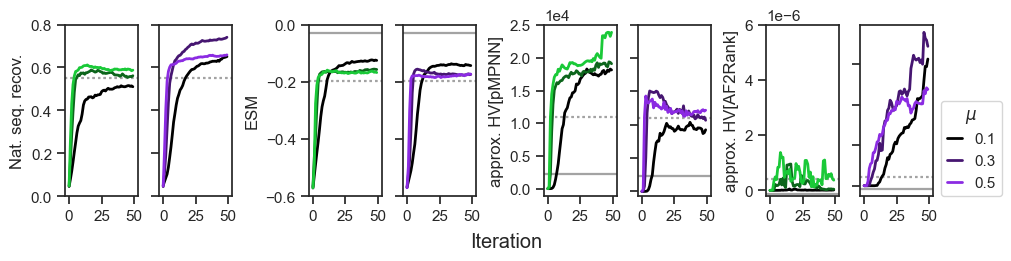

In [17]:
fig, axes= plt.subplots(1, 8, figsize= (10, 2.5), sharex= True, layout= 'constrained')

df_GA_1_dict_list= [df_GA_dict[idx] for idx in [1, 2, 3]]
df_GA_2_dict_list= [df_GA_dict[idx] for idx in [4, 5, 6]]
mu_list= [0.1, 0.3, 0.5]

color_idx= 0
for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for mu_idx, (mu, df1, df2) in enumerate(zip(mu_list, df_GA_1_dict_list, df_GA_2_dict_list)):
        for idx, data_dict in enumerate([df1, df2]):
            ax= axes[2*metric_idx + idx]

            ax.axhline(df_AD_dict[metric], color= bright_colors[-3], linestyle= 'dotted', zorder= 0)
            if metric_idx != 0:
                ax.axhline(wt_dict[metric], color= bright_colors[-3], linestyle= 'solid', zorder= 0)

            y_data= data_dict[metric]
            x_data= list(range(len(y_data)))
            sns.lineplot(
                x= x_data, y= y_data,
                linewidth= 2,
                color= hex_interpolate(
                    [0, 0, 0], 
                    bright_colors[2] if idx == 0 else bright_colors[4], 
                    mu_idx/(len(mu_list) - 1)
                ),
                label= mu,
                ax= ax
            )
            color_idx+= 1

            ax.set(
                xlim= [-3, 53],
                xticks= [0, 25, 50],
                #title= f'{settings["choose_pos_method"]},{settings["choose_AA_method"]}\n{settings["objective_type"]}\n{idx-6}-{idx}' if metric_idx == 0 else ''
            )

            
            if metric_idx == 0:
                ax.set(yticks= [0., 0.2, 0.4, 0.6, 0.8])
            elif metric_idx == 1:
                ax.set(yticks= [-0.6, -0.4, -0.2, 0])
            elif metric_idx == 2:
                ax.set(yticks= [0., 5000, 10000, 15000, 20000, 25000])
                if mu_idx == 0:
                    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
            elif metric_idx == 3:
                if mu_idx == 0:
                    ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
                ax.set(yticks= [0, 2e-6, 4e-6, 6e-6])

            try:
                ax.get_legend().remove()
            except:
                pass

            if idx == 1:
                ax.set(yticklabels= [])

axes[0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[2].set(
    ylabel= 'ESM'
)
axes[4].set(
    ylabel= 'approx. HV[pMPNN]'
)
axes[6].set(
    ylabel= 'approx. HV[AF2Rank]'
)

ax= axes[7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mu_list, title= r'$\mu$',
    bbox_to_anchor= (1, 0.60), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.align_labels()
fig.supxlabel('Iteration')

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/fig_parts/CaM_GA_benchmark_stats.svg', bbox_inches='tight', dpi= 600)

Sequence anlaysis plot

In [18]:
pca_af2rank = PCA(n_components=3, random_state= 1)

ga_af2rank_df= df_GA_dict[5]['df'][-1][af2rank_metrics_list + ['candidate']].copy()
ga_af2rank_df['method']= 'GA[AF2Rank]'

ga_pmpnn_df= df_GA_dict[2]['df'][-1][af2rank_metrics_list + ['candidate']].copy()
ga_pmpnn_df['method']= 'GA[pMPNN]'

ad_df= df_AD_dict['df'][af2rank_metrics_list + ['candidate']].copy()
ad_df['method']= 'AD'

wt_dict= {k: wt_data[k] for k in af2rank_metrics_list + ['candidate']}
wt_dict['method']= 'WT'

af2rank_df= pd.concat(
    [ad_df, ga_pmpnn_df, ga_af2rank_df],
).reset_index(drop= True).append(wt_dict, ignore_index= True)

af2rank_pca_df= pd.DataFrame(
    pca_af2rank.fit_transform(
        af2rank_df[af2rank_metrics_list]
    ),
    columns= ['PC1', 'PC2', 'PC3']
)

af2rank_pca_df= pd.merge(
    left= af2rank_df,
    right= af2rank_pca_df,
    left_index= True,
    right_index= True,
    validate= '1:1'
)

In [19]:
pca_pmpnn = PCA(n_components=2, random_state= 1)

ga_af2rank_df= df_GA_dict[5]['df'][-1][pmpnn_metrics_list + ['candidate']].copy()
ga_af2rank_df['method']= 'GA[AF2Rank]'

ga_pmpnn_df= df_GA_dict[2]['df'][-1][pmpnn_metrics_list + ['candidate']].copy()
ga_pmpnn_df['method']= 'GA[pMPNN]'

ad_df= df_AD_dict['df'][pmpnn_metrics_list + ['candidate']].copy()
ad_df['method']= 'AD'

wt_dict= {k: wt_data[k] for k in pmpnn_metrics_list + ['candidate']}
wt_dict['method']= 'WT'

pmpnn_df= pd.concat(
    [ad_df, ga_pmpnn_df, ga_af2rank_df],
).reset_index(drop= True).append(wt_dict, ignore_index= True)

pmpnn_pca_df= pd.DataFrame(
    pca_pmpnn.fit_transform(
        pmpnn_df[pmpnn_metrics_list]
    ),
    columns= ['PC1', 'PC2']
)
pmpnn_pca_df= pd.merge(
    left= pmpnn_df,
    right= pmpnn_pca_df,
    left_index= True,
    right_index= True,
    validate= '1:1'
)

In [20]:
msa_ga_pmpnn= logomaker.alignment_to_matrix(df_GA_dict[2]['df'][-1]['candidate'], to_type= 'counts')
msa_ga_af2rank= logomaker.alignment_to_matrix(df_GA_dict[5]['df'][-1]['candidate'], to_type= 'counts')
msa_AD= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'], to_type= 'counts')
all_resids= des_resids
all_resids_idx= pd.Index(all_resids, name= 'pos')
msa_ga_pmpnn.index= all_resids_idx
msa_ga_af2rank.index= all_resids_idx
msa_AD.index= all_resids_idx

entropy_GA1= []
for idx, pos in msa_ga_pmpnn.iterrows():
    entropy_GA1.append(entropy(list(pos)))

entropy_GA2= []
for idx, pos in msa_ga_af2rank.iterrows():
    entropy_GA2.append(entropy(list(pos)))

entropy_AD= []
for idx, pos in msa_AD.iterrows():
    entropy_AD.append(entropy(list(pos)))

In [21]:
blosum_matrix= []
for candidate_1, method_1 in zip(af2rank_pca_df['candidate'], af2rank_pca_df['method']):
    blosum_dists= []
    for candidate_2, method_2 in zip(af2rank_pca_df['candidate'], af2rank_pca_df['method']):
        blosum_dist= aligner.align(str(candidate_1), str(candidate_2)).score/len(candidate_1)
        blosum_dists.append(blosum_dist)
    blosum_matrix.append(blosum_dists)
blosum_matrix= np.asarray(blosum_matrix)

embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
blosum_matrix_transformed = embedding.fit_transform(blosum_matrix)

embedding_df= pd.DataFrame(
    {
        'seq_embed_1': blosum_matrix_transformed[:, 0], 
        'seq_embed_2': blosum_matrix_transformed[:, 1], 
        'method': af2rank_pca_df['method'],
        'candidate': af2rank_pca_df['candidate']
    }
)

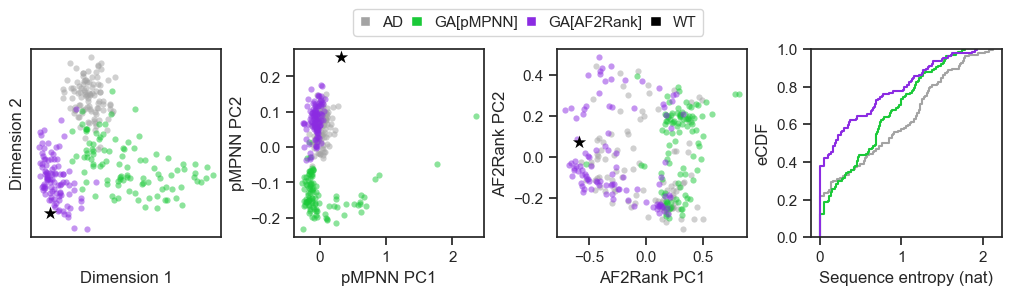

In [22]:
alpha= 0.5
s= 20

fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained')

x_data= 'PC1'
y_data= 'PC2'
ax= axes[1]
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= pmpnn_pca_df[pmpnn_pca_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= 'pMPNN PC1', ylabel= 'pMPNN PC2'
)
ax.get_legend().remove()
#ax.set_aspect('equal')


x_data= 'PC1'
y_data= 'PC2'
ax= axes[2]
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= af2rank_pca_df[af2rank_pca_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= 'AF2Rank PC1', ylabel= 'AF2Rank PC2'
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[0]
x_data= 'seq_embed_1'
y_data= 'seq_embed_2'
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA[pMPNN]'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA[AF2Rank]'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)

ax.set(
    xlabel= 'Dimension 1', ylabel= 'Dimension 2',
    xticks= [], xticklabels= [], yticks= [], yticklabels= []
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[3]
sns.ecdfplot(x= entropy_AD, ax= ax, color= bright_colors[-3])
sns.ecdfplot(x= entropy_GA1, ax= ax, color= bright_colors[2])
sns.ecdfplot(x= entropy_GA2, ax= ax, color= bright_colors[4])

ax.set(xlabel= 'Sequence entropy (nat)', ylabel= 'eCDF')

#plt.legend(loc= 'lower right')

fig.align_labels()

handles= [
    mpatches.Patch(facecolor= bright_colors[-3], label= 'AD'),
    mpatches.Patch(facecolor= bright_colors[2], label= 'GA[pMPNN]'),
    mpatches.Patch(facecolor= bright_colors[4], label= 'GA[AF2Rank]'),
    mpatches.Patch(facecolor= (0, 0, 0), label= 'WT')
]

fig.legend(
    handles= handles,
    bbox_to_anchor= (0.34, 1.15), loc= 'upper left',
    ncol= 6, columnspacing= 0.5, handlelength= 0.7
)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/fig_parts/CaM_benchmark_scatter.svg', bbox_inches='tight', dpi= 600)

Interface ddG analysis

In [23]:
import pyrosetta as pyr
from pyrosetta.rosetta.core.select import residue_selector
from pyrosetta.rosetta.protocols.grafting import simple_movers

In [24]:
pyr.init('-out:level 100 -beta_nov16 -ignore_zero_occupancy false')

PyRosetta-4 2022 [Rosetta PyRosetta4.Release.python310.linux 2022.45+release.20a5bfe160d0310bb7266ea8124fa2b8c5d99c1c 2022-11-07T08:55:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [25]:
sfxn= pyr.create_score_function(f'beta_nov16.wts')

In [26]:
wt_poses= {}
for pdb_file in chains_neighbors_pdb_files:
    wt_poses[pdb_file]= pyr.pose_from_pdb(f'data/charge_complementarity_pdb_files/wt/{pdb_file}.pdb')

mut_poses= {}
for pdb_file in chains_neighbors_pdb_files:
    mut_poses[pdb_file]= pyr.pose_from_pdb(f'data/charge_complementarity_pdb_files/mutant/{pdb_file}.pdb')

In [27]:
def pose_elec_score(pose):
    return pose.scores['fa_elec'] + pose.scores['fa_intra_elec']

def pose_total_score(pose):
    return pose.scores['total_score']

In [28]:
dd_elec_list= []
int_dd_elec_list= []
int_dd_total_list= []
for wt_pose, mut_pose, chain_ids in zip(wt_poses.values(), mut_poses.values(), chains_neighbors_list):
    cam_chain_ids= [chain_id for chain_id in chain_ids if chain_id in CaM_chain_ids]
    other_chain_ids= [chain_id for chain_id in chain_ids if chain_id not in CaM_chain_ids]

    n_cam= len(cam_chain_ids)
    
    if len(other_chain_ids) == 0:
        dd_elec_list.append(np.nan)
        int_dd_elec_list.append(np.nan)
        int_dd_total_list.append(np.nan)
    else:
        sfxn(wt_pose)
        sfxn(mut_pose)

        chain_deletor= simple_movers.DeleteRegionMover()
        chain_deletor.set_residue_selector(residue_selector.NotResidueSelector(residue_selector.ChainSelector(','.join(cam_chain_ids))))
        wt_pose_cam_only= wt_pose.clone()
        chain_deletor.apply(wt_pose_cam_only)
        sfxn(wt_pose_cam_only)
        mut_pose_cam_only= mut_pose.clone()
        chain_deletor.apply(mut_pose_cam_only)
        sfxn(mut_pose_cam_only)

        chain_deletor= simple_movers.DeleteRegionMover()
        chain_deletor.set_residue_selector(residue_selector.NotResidueSelector(residue_selector.ChainSelector(','.join(other_chain_ids))))
        wt_pose_other_only= wt_pose.clone()
        chain_deletor.apply(wt_pose_other_only)
        sfxn(wt_pose_other_only)
        mut_pose_other_only= mut_pose.clone()
        chain_deletor.apply(mut_pose_other_only)
        sfxn(mut_pose_other_only)

        dd_elec_list.append(
            (pose_elec_score(mut_pose) - pose_elec_score(wt_pose))/n_cam
        )
        int_dd_elec_list.append(
            (
                (pose_elec_score(mut_pose) - (pose_elec_score(mut_pose_cam_only) + pose_elec_score(mut_pose_other_only))) - 
                (pose_elec_score(wt_pose) - (pose_elec_score(wt_pose_cam_only) + pose_elec_score(wt_pose_other_only)))
            )/n_cam
        )
        int_dd_total_list.append(
            (
                (pose_total_score(mut_pose) - (pose_total_score(mut_pose_cam_only) + pose_total_score(mut_pose_other_only))) - 
                (pose_total_score(wt_pose) - (pose_total_score(wt_pose_cam_only) + pose_total_score(wt_pose_other_only)))
            )/n_cam
        )

In [29]:
charge_counts= [
    (seq.count('K') + seq.count('R')) - (seq.count('E') + seq.count('D'))
    for seq in pmpnn_pca_df['candidate']
]

charge_df= af2rank_pca_df.copy(deep=True)
charge_df['charge_counts']= charge_counts

ad_charge_per_pos= (((msa_AD['K'] + msa_AD['R']) - (msa_AD['E'] + msa_AD['D']))/len(df_AD_dict['df']['candidate'])).reindex(list(range(6, 146)), fill_value= np.nan)
ga_pmpnn_charge_per_pos= (((msa_ga_pmpnn['K'] + msa_ga_pmpnn['R']) - (msa_ga_pmpnn['E'] + msa_ga_pmpnn['D']))/len(df_GA_dict[2]['df'][-1]['candidate'])).reindex(list(range(6, 146)), fill_value= np.nan)
ga_af2rank_charge_per_pos= (((msa_ga_af2rank['K'] + msa_ga_af2rank['R']) - (msa_ga_af2rank['E'] + msa_ga_af2rank['D']))/len(df_GA_dict[5]['df'][-1]['candidate'])).reindex(list(range(6, 146)), fill_value= np.nan)

charge content & interface ddE plot

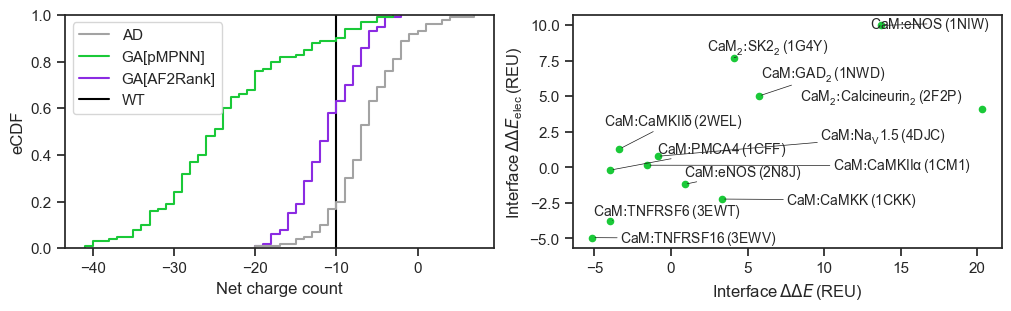

In [30]:
fig, axes= plt.subplots(1, 2, figsize= (10, 3), layout= 'constrained')

#sns.ecdfplot(x= charge_df[charge_df['method'] == 'AD']['charge_counts'], ax= axes[0], color= bright_colors[-3])
#sns.ecdfplot(x= charge_df[charge_df['method'] == 'GA[pMPNN]']['charge_counts'], ax= axes[0], color= bright_colors[2])
#sns.ecdfplot(x= charge_df[charge_df['method'] == 'GA[AF2Rank]']['charge_counts'], ax= axes[0], color= bright_colors[4])
#axes[0].axvline(charge_df[charge_df['method'] == 'WT']['charge_counts'].squeeze(), color= 'black')

g= sns.ecdfplot(
    data= charge_df,
    x= 'charge_counts',
    hue= 'method',
    palette= {'AD': bright_colors[-3], 'GA[pMPNN]': bright_colors[2], 'GA[AF2Rank]': bright_colors[4], 'WT': 'black'},
    ax= axes[0]
)
g.legend_.set_title(None)
axes[0].set(xlabel= 'Net charge count', ylabel= 'eCDF')


axes[1].scatter(
    x= int_dd_total_list,
    y= int_dd_elec_list,
    color= bright_colors[2],
    s= 20
)
axes[1].set(
    xlabel= r'$\mathregular{Interface}\, {\Delta\Delta}E\, \mathregular{(REU)}$',
    ylabel= r'$\mathregular{Interface}\, {\Delta\Delta}E_{\mathregular{elec}}\, \mathregular{(REU)}$'
)

texts= []
for x, y, name in zip(int_dd_total_list, int_dd_elec_list, metric_complex_names):
    if np.isnan(x) or np.isnan(y):
        pass
    else:
        texts.append(
            axes[1].text(
                s= name,
                x= x, 
                y= y,
                fontsize= 10
            )
        )

adjust_text(texts, ax= axes[1], arrowprops=dict(arrowstyle="-", color='k', lw=0.5))

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_charge_scatter.svg', bbox_inches='tight', dpi= 600)

Charge content seq distribution plot

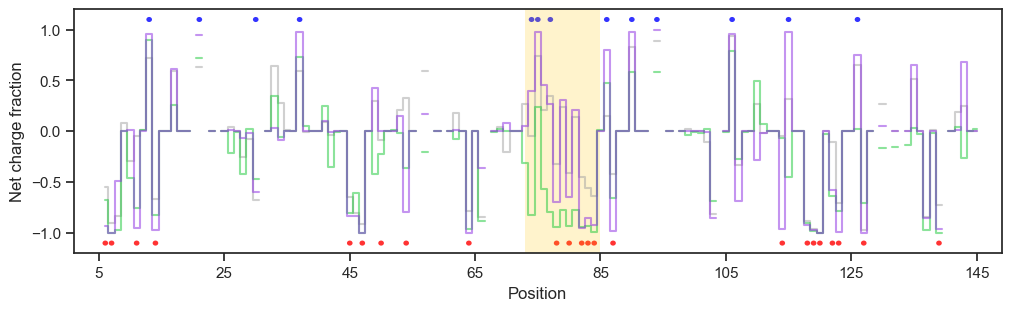

In [33]:
fig, ax= plt.subplots(1, 1, figsize= (10, 3), layout= 'constrained')

ax.step(
    x= ad_charge_per_pos.index,
    y= ad_charge_per_pos.values,
    where= 'mid',
    color= bright_colors[-3],
    alpha= 0.5,
)
ax.step(
    x= ga_pmpnn_charge_per_pos.index,
    y= ga_pmpnn_charge_per_pos.values,
    where= 'mid',
    color= bright_colors[2],
    alpha= 0.5,
)
ax.step(
    x= ga_af2rank_charge_per_pos.index,
    y= ga_af2rank_charge_per_pos.values,
    where= 'mid',
    color= bright_colors[4],
    alpha= 0.5,
)

ax.set(
    xlabel= 'Position',
    ylabel= 'Net charge fraction',
    xlim= (1, 149),
    xticks= (5, 25, 45, 65, 85, 105, 125, 145),
    ylim= (-1.2, 1.2)
)

for resid, aa in zip(des_resids, wt_data['candidate']):
    if aa in ['R', 'K']:
        circle = Ellipse((resid, 1.1), 0.9, 0.05, color='blue', alpha= 0.8, linewidth= 0)
        ax.add_patch(circle)
    elif aa in ['E', 'D']:
        circle = Ellipse((resid, -1.1), 0.9, 0.05, color='red', alpha= 0.8, linewidth= 0)
        ax.add_patch(circle)

linker_region= Rectangle((73, -1.2), 12, 2.4, color= bright_colors[-2], alpha= 0.2, linewidth= 0)
ax.add_patch(linker_region)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_charge_steps.svg', bbox_inches='tight', dpi= 600)

Pairwise TM-score plot

In [34]:
# read in TMscore and GDT_TS scores
tmscore_matrix= np.loadtxt('data/pdb_files_single_chain_trimmed/pairwise_tms.txt')
embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
tmscore_matrix_transformed = embedding.fit_transform(tmscore_matrix)
tmscore_embedding_df= pd.DataFrame(
    {
        'seq_embed_1': tmscore_matrix_transformed[:, 0], 
        'seq_embed_2': tmscore_matrix_transformed[:, 1], 
        'pdb_name': chains_neighbors_pdb_files,
        'complex_name': metric_complex_names
    }
)

In [35]:
pca_pmpnn_full = PCA(n_components=14, random_state= 1)
pca_pmpnn_full.fit(pmpnn_pca_df.loc[pmpnn_pca_df['method'] == 'GA[pMPNN]', pmpnn_metrics_list].drop(index= [122, 130], errors= 'ignore'))

pca_af2rank_full = PCA(n_components=14, random_state= 1)
pca_af2rank_full.fit(af2rank_pca_df.loc[af2rank_pca_df['method'] == 'GA[AF2Rank]', af2rank_metrics_list].drop(index= [122, 130], errors= 'ignore'))

PCA(n_components=14, random_state=1)

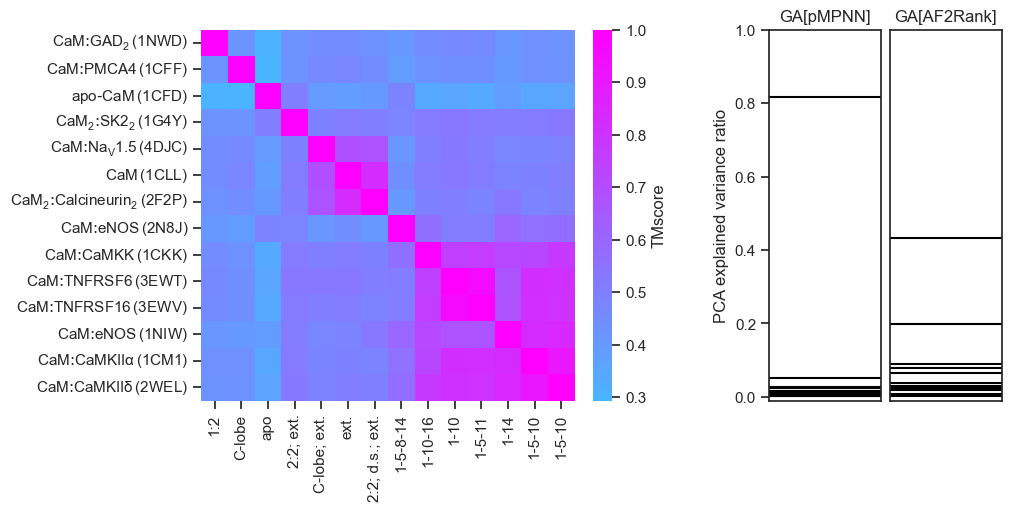

In [36]:
fig, axes= plt.subplots(1, 4, figsize= (10, 5), layout= 'constrained', width_ratios= [5, 0.4, 1.5, 1.5])

tm_disimilarity_matrix= 1 - tmscore_matrix
dissimilarity_vec= squareform(tm_disimilarity_matrix, force= 'tovector')
hierarchy= linkage(dissimilarity_vec, method= 'single')
dn= dendrogram(hierarchy, no_plot= True)

sns.heatmap(
    tmscore_matrix[dn['leaves']].T[dn['leaves']], 
    center= 0.5, 
    cmap= 'cool',
    ax= axes[0],
    cbar_kws={'label': 'TMscore'}
)

axes[0].set_xticklabels([complex_conformation_annotation[idx] for idx in dn['leaves']], rotation= 90)
axes[0].set_yticklabels([metric_complex_names[idx] for idx in dn['leaves']], rotation= 0)

axes[1].axis('off')

for eigval in pca_pmpnn_full.explained_variance_ratio_:
    axes[2].axhline(eigval, color= 'black')

axes[2].set(
    ylim= (-0.01, 1),
    xticks= [],
    ylabel= 'PCA explained variance ratio',
    title= 'GA[pMPNN]'
)

for eigval in pca_af2rank_full.explained_variance_ratio_:
    axes[3].axhline(eigval, color= 'black')

axes[3].set(
    ylim= (-0.01, 1),
    xticks= [], yticks= [],
    title= 'GA[AF2Rank]'
)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_PCA_1.svg', bbox_inches='tight', dpi= 600)

Objective space PCA loading plot

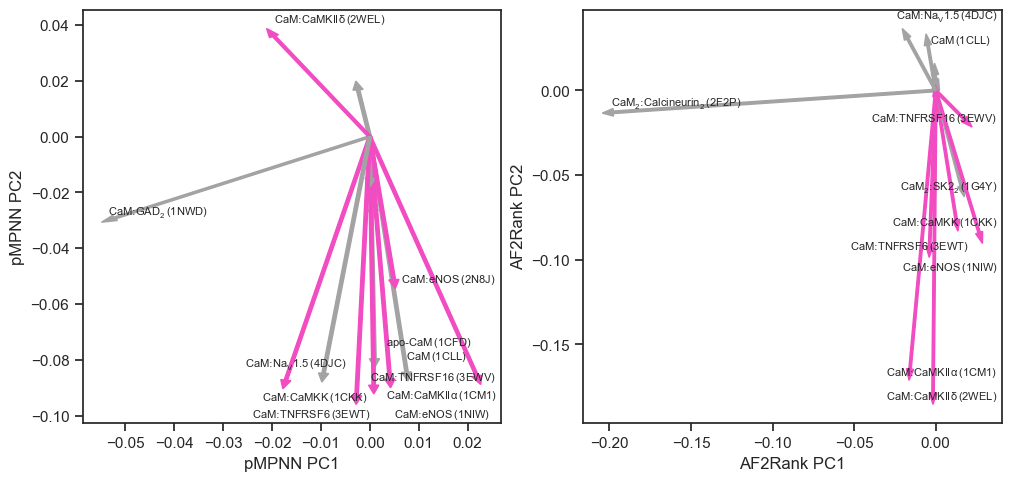

In [37]:
fig, axes= plt.subplots(1, 2, figsize= (10, 4.7), layout= 'constrained')

pca_pmpnn_component1= pca_pmpnn_full.components_[0]
pca_pmpnn_component2= pca_pmpnn_full.components_[1]

pca_pmpnn_eigval1= pca_pmpnn_full.explained_variance_[0]
pca_pmpnn_eigval2= pca_pmpnn_full.explained_variance_[1]

pca_pmpnn_load1= pca_pmpnn_component1*np.sqrt(pca_pmpnn_eigval1)
pca_pmpnn_load2= pca_pmpnn_component2*np.sqrt(pca_pmpnn_eigval2)


pca_af2rank_component1= pca_af2rank_full.components_[0]
pca_af2rank_component2= pca_af2rank_full.components_[1]

pca_af2rank_eigval1= pca_af2rank_full.explained_variance_[0]
pca_af2rank_eigval2= pca_af2rank_full.explained_variance_[1]

pca_af2rank_load1= pca_af2rank_component1*np.sqrt(pca_af2rank_eigval1)
pca_af2rank_load2= pca_af2rank_component2*np.sqrt(pca_af2rank_eigval2)


for idx, loadings in enumerate([
    [pca_pmpnn_load1, pca_pmpnn_load2],
    [pca_af2rank_load1, pca_af2rank_load2]
]):
    load1, load2= loadings
    texts= []
    for dx, dy, complex_name, complex_annotation in zip(
        load1,
        load2,
        metric_complex_names,
        complex_conformation_annotation
    ):
        if '1-' in complex_annotation:
            color= bright_colors[-4]
        else:
            color= bright_colors[-3]

        vec_len= np.sqrt(dx**2 + dy**2)

        axes[idx].arrow(
            x= 0, y= 0,
            dy= -dx, dx= -dy,
            length_includes_head=True,
            width= 0.0015 if idx == 1 else 0.0007,
            color= color,
        )

        if vec_len < 0.03:
            pass
        else:
            texts.append(
                axes[idx].text(
                    s= complex_name,
                    y= -dx, 
                    x= -dy,
                    fontsize= 8
                )
            )

    adjust_text(texts, ax= axes[idx])

axes[0].set(
    xlabel= 'pMPNN PC1', ylabel= 'pMPNN PC2'
)
axes[1].set(
    xlabel= 'AF2Rank PC1', ylabel= 'AF2Rank PC2'
)

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_PCA_2.svg', bbox_inches='tight', dpi= 600)

Per-position dimensionality analysis

In [39]:
logits_dict= {resid: torch.load(f'data/CaM_AD_pMPNN_logits/logits_{resid}.pt')[:, :20] for resid in des_resids}

In [40]:
def get_n_clusters_dict(corr_cutoff):
    n_clusters_dict= {}
    for resid, logits in logits_dict.items():
        dissimilarity_mat= 1. - torch.corrcoef(logits).numpy()
        dissimilarity_vec= squareform(dissimilarity_mat, checks= False, force= 'tovector')
        hierarchy= linkage(dissimilarity_vec, method= 'single')
        labels= fcluster(hierarchy, 1 - corr_cutoff, criterion= 'distance') - 1
        n_clusters= np.max(labels) + 1
        n_clusters_dict[resid]= n_clusters
    return n_clusters_dict

In [41]:
pearson_r_list= []
for resid, logits in logits_dict.items():
    pearson_r_list.append(squareform(np.corrcoef(logits), checks= False, force= 'tovector'))

pearson_r_list= np.concatenate(pearson_r_list)

In [42]:
n_clusters_cutoff_dict= {}

for cutoff in np.linspace(0.4, 0.95, 12):
    n_clusters= list(get_n_clusters_dict(cutoff).values())
    n_clusters_cutoff_dict[cutoff]= n_clusters

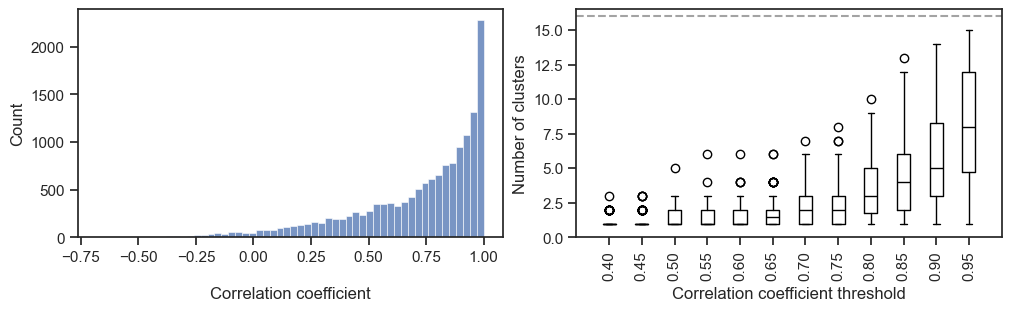

In [43]:
fig, axes= plt.subplots(1, 2, figsize= (10, 3), layout= 'constrained')

sns.histplot(pearson_r_list, ax= axes[0])
axes[0].set(xlabel= 'Correlation coefficient')

axes[1].boxplot(
    x= list(n_clusters_cutoff_dict.values()),
    positions= list(n_clusters_cutoff_dict.keys()),
    widths= 0.02,
    medianprops= dict(color= 'black'),
)

axes[1].set(
    xlim= (0.35, 1), ylim= (0, 16.5),
    xlabel= 'Correlation coefficient threshold',
    ylabel= 'Number of clusters'
)
axes[1].set_xticklabels([f'{cutoff:.2f}' for cutoff in n_clusters_cutoff_dict.keys()], rotation= 90)

axes[1].axhline(16, linestyle= '--', color= bright_colors[-3])

fig.align_xlabels()

plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_per_pos_dim_1.svg', bbox_inches='tight', dpi= 600)

Per-position seq recovery vs effective dimensionality plot

In [44]:
per_position_dim_dict= get_n_clusters_dict(0.8)
per_position_dim_df= pd.DataFrame({'dim': per_position_dim_dict.values()}, index= per_position_dim_dict.keys()).reindex(list(range(6, 146)), fill_value= np.nan)

In [45]:
def per_pos_recovery_frac(msa):
    recovery_frac= []
    for wt_aa, (resid, seq_distr) in zip(wt_data['candidate'], msa.iterrows()):
        recovery_frac.append(seq_distr[wt_aa]/seq_distr.sum())
    return recovery_frac

In [46]:
recovery_df= pd.DataFrame(
    {
        'AD': per_pos_recovery_frac(msa_AD),
        'GA[pMPNN]': per_pos_recovery_frac(msa_ga_pmpnn),
        'GA[AF2Rank]': per_pos_recovery_frac(msa_ga_af2rank)
    },
    index= des_resids
)

recovery_df= pd.merge(
    left= per_position_dim_df,
    right= recovery_df,
    left_index= True,
    right_index= True,
    validate= '1:1'
)

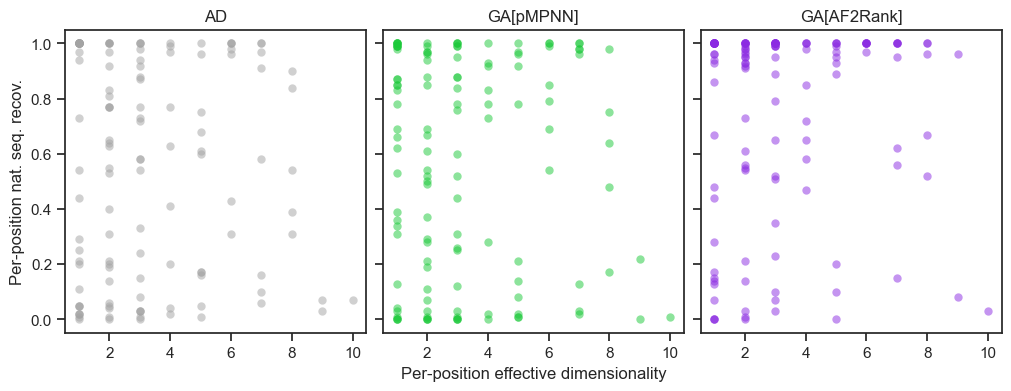

In [48]:
fig, axes= plt.subplots(1, 3, figsize= (10, 3.8), layout= 'constrained', sharex= True, sharey= True)

for idx, method in enumerate(['AD', 'GA[pMPNN]', 'GA[AF2Rank]']):
    if idx == 0:
        color= bright_colors[-3]
    elif idx == 1:
        color= bright_colors[2]
    else:
        color= bright_colors[4]

    sns.scatterplot(
        data= recovery_df,
        x= 'dim',
        y= method,
        ax= axes[idx],
        linewidth= 0,
        alpha= 0.5,
        color= color,
    )

    axes[idx].set(xlabel= '', title= method)

axes[1].set(xlabel= 'Per-position effective dimensionality')
axes[0].set(ylabel= 'Per-position nat. seq. recov.')
plt.show()

#fig.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_per_pos_dim_2.svg', bbox_inches='tight', dpi= 600)

Sequence logo plots

In [49]:
def get_sub_msa(resid_sublist, supylabel):
    idx0= [des_resids.index(resid) for resid in resid_sublist]

    fig, axes= plt.subplots(3, 1, figsize= (10, 3*1.1), layout= 'constrained', sharex= True)

    msa= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'].values, to_type= 'counts')
    logomaker.Logo(msa.loc[idx0].reset_index(drop= True), ax= axes[0], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    axes[0].set(ylabel= 'AD', yticks= [])

    msa= logomaker.alignment_to_matrix(df_GA_dict[2]['df'][-1]['candidate'].values, to_type= 'counts')
    logomaker.Logo(msa.loc[idx0].reset_index(drop= True), ax= axes[1], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    axes[1].set(ylabel= 'GA[pMPNN]', yticks= [])

    msa= logomaker.alignment_to_matrix(df_GA_dict[5]['df'][-1]['candidate'].values, to_type= 'counts')
    logomaker.Logo(msa.loc[idx0].reset_index(drop= True), ax= axes[2], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    axes[2].set(
        xticks= list(range(len(idx0))), xlabel= 'Designable positions',
        yticks= [], ylabel= 'GA[AF2]'
    )
    axes[2].set_xticklabels(resid_sublist, rotation= 90)

    ax2= axes[0].twiny()
    ax2.set_xlim(axes[0].get_xlim())
    ax2.set_xticks(np.array(range(len(idx0))))
    ax2.set_xticklabels(np.array(list(wt_data['candidate']))[idx0])

    fig.align_ylabels()
    fig.supylabel(supylabel)

    return fig

In [50]:
ef1_resid_sublist= [resid for resid in des_resids if resid <=39]
ef2_resid_sublist= [resid for resid in des_resids if 40 <= resid and resid <=75]
ef3_resid_sublist= [resid for resid in des_resids if 76 <= resid and resid <=112]
ef4_resid_sublist= [resid for resid in des_resids if resid > 112]

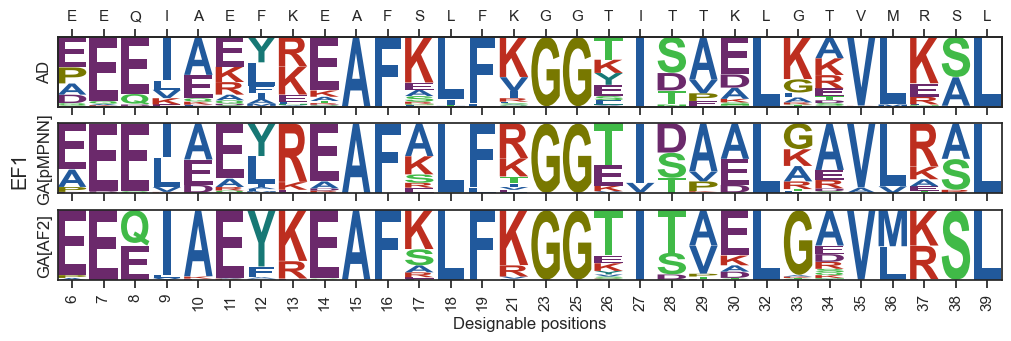

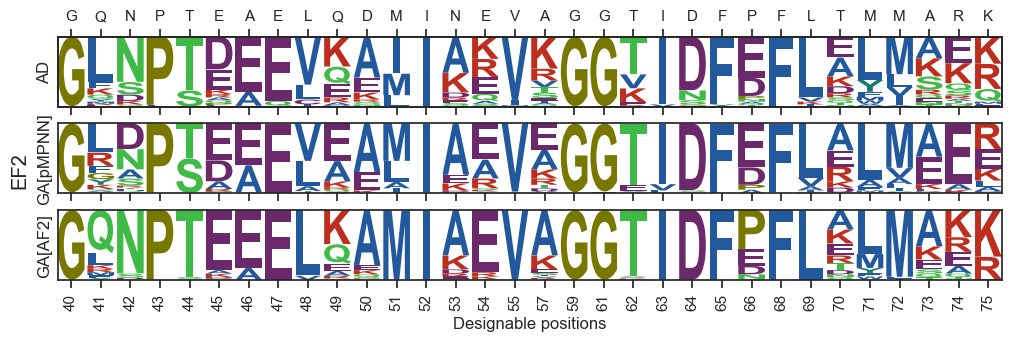

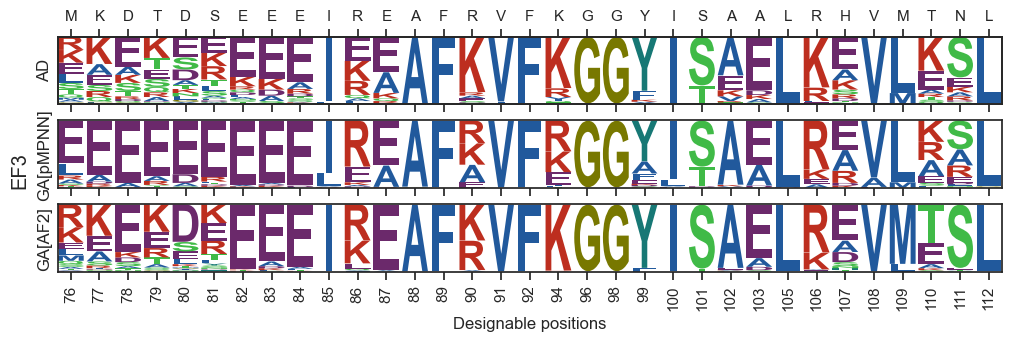

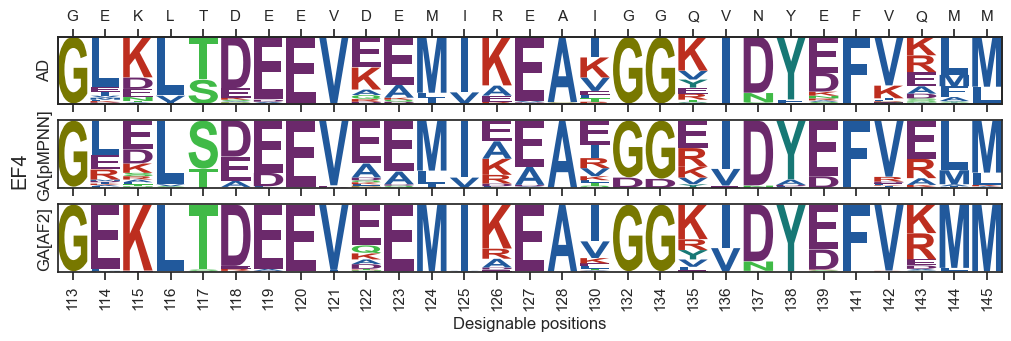

In [51]:
fig_ef1= get_sub_msa(ef1_resid_sublist, 'EF1')
fig_ef2= get_sub_msa(ef2_resid_sublist, 'EF2')
fig_ef3= get_sub_msa(ef3_resid_sublist, 'EF3')
fig_ef4= get_sub_msa(ef4_resid_sublist, 'EF4')

#fig_ef1.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_MSA_1.svg', bbox_inches='tight', dpi= 600)
#fig_ef2.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_MSA_2.svg', bbox_inches='tight', dpi= 600)
#fig_ef3.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_MSA_3.svg', bbox_inches='tight', dpi= 600)
#fig_ef4.savefig('/home/lu/Dropbox/multistate_paper/SI_fig_parts/CaM_MSA_4.svg', bbox_inches='tight', dpi= 600)